In [107]:
#Preprocessing: importing our data

import numpy as np
import pandas as pd


ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
display(ratings_df.head(10))

movies_df = pd.read_csv('ml-latest-small/movies.csv')
display(movies_df.head(10))


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [108]:
#Preprocessing: splitting our data into training and testing sets

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(ratings_df, test_size=0.2)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

train_data.head(10)

,userId,movieId,rating,timestamp
0,483,66934,4.0,1238025112
1,480,46970,5.0,1179165610
2,31,1361,5.0,850466810
3,148,98491,5.0,1482548665
4,378,858,3.0,1445345918
5,232,52458,3.5,1180747388
6,139,4148,1.5,1453924446
7,23,1193,3.5,1107163763
8,387,1172,3.5,1178548871
9,599,44761,3.0,1498522158


Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


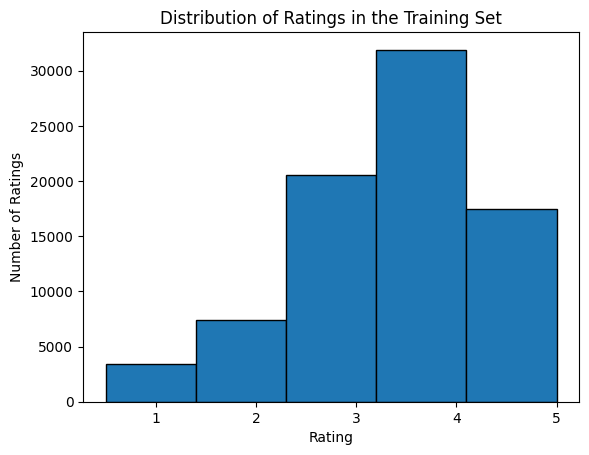

In [109]:
#Data Visualization/EDA: visualizing our data

import matplotlib.pyplot as plt


n_ratings = len(ratings_df)
n_movies = ratings_df['movieId'].nunique()
n_users = ratings_df['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

plt.hist(train_data['rating'], bins=5, edgecolor='black')

plt.title('Distribution of Ratings in the Training Set')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.show()

In [110]:
#Rating prediction: k-Nearest Neighbors

#creating sparse matrix from ratings 
from scipy.sparse import csr_matrix

def create_X(df):
    
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings_df)


In [111]:
#Data analysis: sparsity of the matrix

display(X)
print(X.shape)

n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

n_ratings_per_user = X.getnnz(axis=1)
print("Users:  " + str(len(n_ratings_per_user)))

n_ratings_per_movie = X.getnnz(axis=0)
print("Ratings "+ str(len(n_ratings_per_movie)))

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100836 stored elements and shape (610, 9724)>

(610, 9724)
Matrix sparsity: 1.7%
Users:  610
Ratings 9724
Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


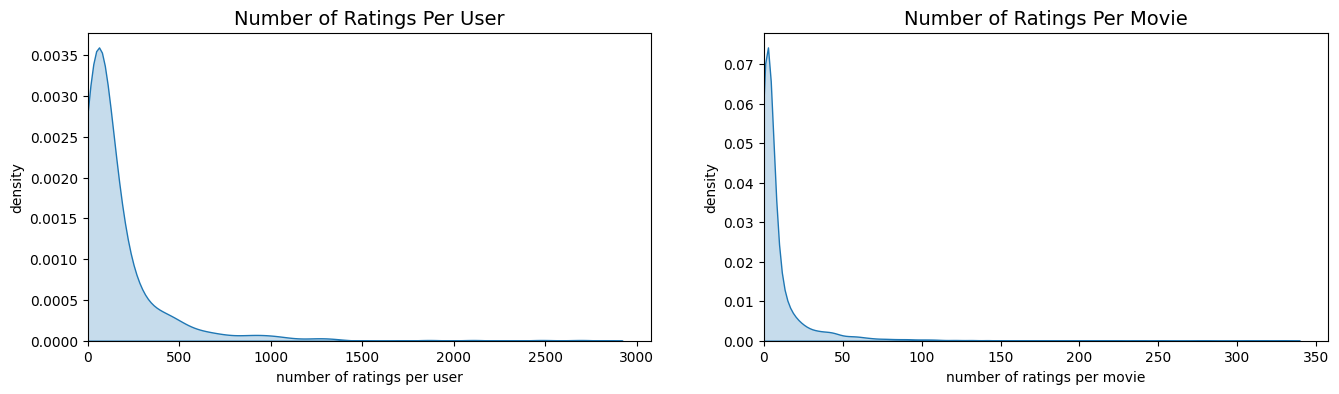

In [112]:
import seaborn as sns

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, fill=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [113]:
#item to item recommendation for nearest k neighbors

from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

    

In [114]:
#testing the function 
similar_movies = find_similar_movies(2, X, movie_mapper, movie_inv_mapper, k=10)

print(f"Because you watched: {movies_df[movies_df['movieId']==2]['title'].values[0]}")

for movie in similar_movies:
    print(movies_df[movies_df["movieId"]==movie]["title"].values[0])

#it works :D

Because you watched: Jumanji (1995)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Mask, The (1994)
Jurassic Park (1993)
Home Alone (1990)
Nightmare Before Christmas, The (1993)
Aladdin (1992)
Beauty and the Beast (1991)
Ace Ventura: When Nature Calls (1995)


In [115]:
#Recommend 10 movies for each user 

from collections import Counter

def recommend_movies_for_user(user_id, user_ratings, X, movie_mapper, movie_inv_mapper, movies_df, k=10):
    
    # Step 1: Get the movies the user has interacted with
    user_movies = user_ratings[user_ratings['userId'] == user_id]['movieId'].tolist()
    
    # Step 2: Find similar movies for each watched movie
    similar_movies = []
    for movie_id in user_movies:
        if movie_id in movie_mapper:
            similar_movies.extend(find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k))
    
    # Step 3: Aggregate and rank recommendations
    movie_counts = Counter(similar_movies)
    
    # Step 4: Filter out movies already watched
    recommendations = [
        movie_id for movie_id, _ in movie_counts.most_common(k * 2)
        if movie_id not in user_movies
    ]
    
    # Step 5: Map movie IDs to titles and return top k recommendations
    recommended_titles = [
        movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        for movie_id in recommendations[:k]
    ]
    return recommended_titles

def recommend_movies_for_all_users(user_ratings, X, movie_mapper, movie_inv_mapper, movies_df, k=10):
    
    recommendations = {}
    for user_id in user_ratings['userId'].unique():
        recommendations[user_id] = recommend_movies_for_user(
            user_id, user_ratings, X, movie_mapper, movie_inv_mapper, movies_df, k
        )
    return recommendations

# Example Usage
all_user_recommendations = recommend_movies_for_all_users(
    ratings_df, X, movie_mapper, movie_inv_mapper, movies_df, k=10
)

# Save recommendations to a file
output_file = "user_recommendations_knn.txt"
with open(output_file, "w") as f:
    for user_id, movie_list in all_user_recommendations.items():
        f.write(f"User {user_id}: {', '.join(movie_list)}\n")


#We run into a problem:
#Users with very few interactions (or none) have an insufficient basis for generating recommendations. 
#If the user hasn’t interacted with enough movies, there won’t be enough "seed" movies to find similar ones.
#For some users, fewer than k recommendations are generated

In [116]:
# Let's try a different model: content-based filtering

# We first clean the genres column to make it easier to work with

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

movies_df = pd.read_csv('ml-latest-small/movies.csv')

# **Cleaning the genres column to remove unwanted characters**
# Remove whitespace and clean invalid genres
movies_df["genres"] = movies_df["genres"].str.strip().str.replace(" ", "").str.replace(r"[^a-zA-Z|]", "", regex=True)

# Splitting genres into lists
movies_df["genres"] = movies_df["genres"].str.split("|")

# **Transforming genres into binary columns**
mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(movies_df["genres"]), columns=mlb.classes_, index=movies_df.index)

# Merging with original df
movies_df = pd.concat([movies_df.drop(columns=["genres"]), genre_df], axis=1)

if 'genres' in movies_df.columns:
    movie_genres = movies_df.drop(columns=['movieId', 'title','genres'])
else:
    movie_genres = movies_df.drop(columns=['movieId', 'title'])

display(movie_genres.columns)
print(movie_genres.shape)
display(movie_genres.head(10))

#As we can see, we have 20 genres in total. We have generated a new movies dataframe with 20 binary columns, one for each genre.

Index(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'FilmNoir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'SciFi', 'Thriller', 'War', 'Western',
       'nogenreslisted'],
      dtype='object')

(9742, 20)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,FilmNoir,Horror,IMAX,Musical,Mystery,Romance,SciFi,Thriller,War,Western,nogenreslisted
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [117]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [118]:
movie_index = dict(zip(movies_df['title'], list(movies_df.index)))

def get_content_based_recommendations(title_string, n_recommendations=10):
    idx = movie_index[title_string]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    return similar_movies

similar_movies = get_content_based_recommendations("Cars (2006)")

print(f"Because you watched: Cars (2006)")
for movie in similar_movies:
    print(movies_df.iloc[movie]['title'])

#It works :D 

Because you watched: Cars (2006)
Rugrats Movie, The (1998)
Chicken Run (2000)
Rugrats in Paris: The Movie (2000)
Garfield: The Movie (2004)
Shark Tale (2004)
Bebe's Kids (1992)
Charlie Brown Christmas, A (1965)
Hoodwinked! (2005)
Cars (2006)
Garfield: A Tail of Two Kitties (2006)


In [ ]:
#Recommend 10 movies for each user - content based

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

global_mean_rating = ratings_df['rating'].mean()

def get_user_based_recommendations(user_id, ratings_df, movies_df, n_recommendations=10):
    # User-based collaborative filtering: find users similar to the target user
    user_ratings = ratings_df.pivot(index='userId', columns='movieId', values='rating')
    user_sim = cosine_similarity(user_ratings.fillna(0))  # Create a similarity matrix for users

    # Get the user index and similarity scores
    user_index = user_id - 1  # user_id starts from 1
    sim_scores = list(enumerate(user_sim[user_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get similar users (excluding the target user)
    similar_users = [score[0] for score in sim_scores[1:11]]  # Top 10 similar users
    
    # Get the movies rated by similar users
    similar_users_ratings = ratings_df[ratings_df['userId'].isin(similar_users)]
    
    # Aggregate recommendations: movies rated by similar users
    recommended_movies = similar_users_ratings.groupby('movieId').agg({'rating': 'mean'}).sort_values('rating', ascending=False)
    
    # Filter out movies already rated by the user
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId']
    recommended_movies = recommended_movies[~recommended_movies.index.isin(user_rated_movies)]
    
    # Get top n recommendations
    top_recommended_movies = recommended_movies.head(n_recommendations)
    
    # Return movie titles
    movie_titles = movies_df[movies_df['movieId'].isin(top_recommended_movies.index)]['title'].values
    return movie_titles

def get_all_recommendations(ratings_df, movies_df, n_recommendations=10):
    recommendations_dict = {}
    
    # Loop through all users and get their recommendations
    for user_id in ratings_df['userId'].unique():
        recommended_movies = get_user_based_recommendations(user_id, ratings_df, movies_df, n_recommendations)
        
        # Store the recommendations in the dictionary
        recommendations_dict[user_id] = recommended_movies
    
    return recommendations_dict

def write_recommendations_to_file(recommendations_dict, filename="recommendations2.txt"):
    with open(filename, "w") as file:
        # Loop through all users in the dictionary
        for user_id, recommended_movies in recommendations_dict.items():
            # Format the recommendation string
            recommendation_line = f"User {user_id}: {', '.join(recommended_movies)}\n"
            
            # Write to the file
            file.write(recommendation_line)

# Example usage:
# Get recommendations for all users
recommendations_dict = get_all_recommendations(ratings_df, movies_df)

# Write the recommendations to a text file
write_recommendations_to_file(recommendations_dict)


In [120]:
#NCF model (swag???)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model

# Step 1: Load Data and Preprocess
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')

# Map original movieId to title
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

# Encode user and movie IDs
ratings['user_id'] = ratings['userId'].astype('category').cat.codes
ratings['movie_encoded_id'] = ratings['movieId'].astype('category').cat.codes

# Map encoded movie ID back to original movieId
encoded_to_original_movie_id = dict(zip(
    ratings['movie_encoded_id'], ratings['movieId']
))

# Calculate total number of users and movies
num_users = ratings['user_id'].nunique()
num_movies = ratings['movie_encoded_id'].nunique()

# Split data
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

# Prepare inputs and labels
train_user = train['user_id'].values
train_movie = train['movie_encoded_id'].values
train_labels = (train['rating'] >= 3).astype(int).values

test_user = test['user_id'].values
test_movie = test['movie_encoded_id'].values
test_labels = (test['rating'] >= 3).astype(int).values

# Step 2: Build the Neural Collaborative Filtering (NCF) Model
embedding_dim = 50

# Define input layers
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding layers
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)

# Flatten embeddings
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# Concatenate user and movie embeddings
concat = Concatenate()([user_vector, movie_vector])

# MLP layers
dense_1 = Dense(128, activation='relu')(concat)
dense_2 = Dense(64, activation='relu')(dense_1)
dense_3 = Dense(32, activation='relu')(dense_2)

# Output layer
output = Dense(1, activation='sigmoid')(dense_3)

# Define and compile the model
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Train the Model
history = model.fit(
    [train_user, train_movie], train_labels,
    validation_data=([test_user, test_movie], test_labels),
    epochs=10,
    batch_size=256
)

# Step 4: Evaluate the Model
predictions = model.predict([test_user, test_movie])
auc_score = roc_auc_score(test_labels, predictions)
print(f"AUC Score: {auc_score}")

# Step 5: Recommend Movies for All Users
def recommend_movies_for_all_users(model, num_users, num_movies, encoded_to_original_movie_id, movie_id_to_title, top_n=10):
    recommendations = {}
    for user_id in range(num_users):
        user_vector = np.array([user_id] * num_movies)
        movie_vector = np.arange(num_movies)
        predictions = model.predict([user_vector, movie_vector]).flatten()
        recommended_encoded_ids = predictions.argsort()[-top_n:][::-1]
        
        # Map encoded movie IDs back to original IDs
        recommended_movie_ids = [
            encoded_to_original_movie_id.get(encoded_id, f"Unknown Movie (Encoded ID: {encoded_id})")
            for encoded_id in recommended_encoded_ids
        ]
        
        # Map original movie IDs to titles
        recommended_movie_titles = [
            movie_id_to_title.get(movie_id, f"Unknown Movie (ID: {movie_id})")
            for movie_id in recommended_movie_ids
        ]
        recommendations[user_id] = recommended_movie_titles
    return recommendations

# Step 6: Save Recommendations to File
def save_recommendations_to_file(recommendations, filename="recommendations_ncf.txt"):
    with open(filename, "w") as file:
        for user_id, movie_titles in recommendations.items():
            movie_list = ", ".join(movie_titles)
            file.write(f"User {user_id + 1}: {movie_list}\n")
    print(f"Recommendations saved to {filename}")

# Generate and save recommendations
all_recommendations = recommend_movies_for_all_users(
    model, num_users, num_movies, 
    encoded_to_original_movie_id, movie_id_to_title, top_n=10
)
save_recommendations_to_file(all_recommendations, filename="recommendations_ncf.txt")

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8040 - loss: 0.4813 - val_accuracy: 0.8287 - val_loss: 0.3954
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8490 - loss: 0.3513 - val_accuracy: 0.8320 - val_loss: 0.3950
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8681 - loss: 0.3158 - val_accuracy: 0.8303 - val_loss: 0.4033
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8812 - loss: 0.2868 - val_accuracy: 0.8258 - val_loss: 0.4349
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9016 - loss: 0.2460 - val_accuracy: 0.8169 - val_loss: 0.4608
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9244 - loss: 0.1983 - val_accuracy: 0.8173 - val_loss: 0.5316
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9437 - loss: 0.1547 - val_accuracy: 0.8024 - val_loss: 0.5907
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9570 - loss: 0.1207 - val_accuracy: 0.7976 - val_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
304/304 ━━━

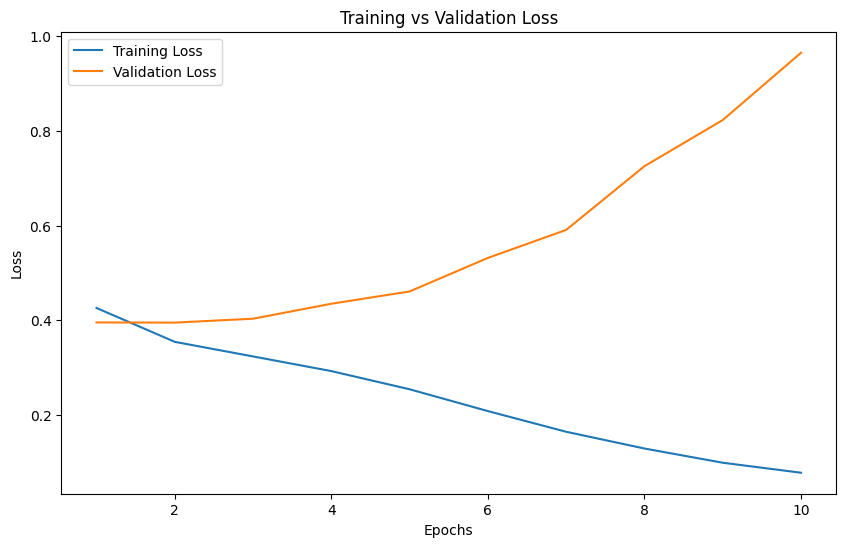

Average Precision: 0.0077302631578947375
Average Recall: 0.0018526905312581388
Average NDCG: 0.004430844635404959
F-Measure: 0.002989012745199075


In [121]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

precisions = []
ndcgs = []
recalls = []
k = 10

test_movies_by_user = test_data.groupby('userId')['movieId'].agg(set).to_dict()
test_ratings_by_user = test_data.groupby(['userId', 'movieId'])['rating'].first().to_dict()

for user_id, recommended_titles in all_recommendations.items():
    if user_id not in test_movies_by_user:
        continue

    # Convert test movie IDs to titles
    test_movie_ids = test_movies_by_user[user_id]
    test_movie_titles = {movie_id_to_title[movie_id] for movie_id in test_movie_ids if movie_id in movie_id_to_title}
    
    # Compute metrics
    recommended_set = set(recommended_titles[:k])
    hits = len(recommended_set.intersection(test_movie_titles))
    
    precision = hits / k if k > 0 else 0
    precisions.append(precision)
    
    recall = hits / len(test_movie_titles) if test_movie_titles else 0
    recalls.append(recall)
    
    # Compute NDCG
    dcg = 0
    idcg = 0

    # Convert recommended titles back to movie IDs for relevance lookup
    recommended_movie_ids = [
        movie_id for movie_id, title in movie_id_to_title.items() if title in recommended_titles[:k]
    ]

    # Compute DCG
    for i, movie_id in enumerate(recommended_movie_ids):
        if movie_id in test_movie_ids:  # Check if movie_id is in the test set
            relevance = test_ratings_by_user.get((user_id, movie_id), 0)  # Get the relevance score
            dcg += (2 ** relevance - 1) / np.log2(i + 2)

    # Compute IDCG (ideal DCG)
    sorted_test_items = sorted(
        [(movie_id, test_ratings_by_user.get((user_id, movie_id), 0)) for movie_id in test_movie_ids],
        key=lambda x: x[1],
        reverse=True
    )
    for i, (_, relevance) in enumerate(sorted_test_items[:k]):
        idcg += (2 ** relevance - 1) / np.log2(i + 2)

    ndcg = dcg / idcg if idcg > 0 else 0
    
    ndcgs.append(ndcg)

# Average metrics
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_ndcg = np.mean(ndcgs)

# F-Measure
f_measure = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average NDCG: {avg_ndcg}')
print(f'F-Measure: {f_measure}')



In [ ]:
#Let's try a hybrid model

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')

movies_df = movies_df[movies_df['movieId'].isin(ratings_df['movieId'].unique())]

# Process Genres for Content Similarity
movies_df['genres'] = movies_df['genres'].str.split('|')
mlb = MultiLabelBinarizer()
# Recompute the genre matrix and content similarity
genre_matrix = mlb.fit_transform(movies_df['genres'])

# Update the movie_mapper and movie_inv_mapper
movie_mapper = dict(zip(movies_df['movieId'], range(len(movies_df))))
movie_inv_mapper = {v: k for k, v in movie_mapper.items()}
content_similarity = cosine_similarity(genre_matrix, genre_matrix)

# Bayesian Rating Adjustment
global_mean_rating = ratings_df['rating'].mean()
# Calculate the count of ratings for each product (movieId)
rating_counts = ratings_df.groupby('movieId')['rating'].count()

# Calculate C as the median.
C = rating_counts.median()

def calculate_bayesian_rating(df, C, global_mean_rating):
    movie_stats = df.groupby('movieId').agg(
        R=('rating', 'mean'),  # Mean rating for the movie
        v=('rating', 'count') # Number of ratings for the movie
    ).reset_index()
    movie_stats['bayesian_rating'] = (
        (movie_stats['v'] * movie_stats['R'] + C * global_mean_rating) / (movie_stats['v'] + C)
    )
    return movie_stats

# Calculate Bayesian ratings using C
movie_stats = calculate_bayesian_rating(ratings_df, C=C, global_mean_rating=global_mean_rating)

# Inspect the resulting DataFrame
print(movie_stats.head())
ratings_df = ratings_df.merge(movie_stats[['movieId', 'bayesian_rating']], on='movieId', how='left')
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer

# Normalize Ratings
def normalize_ratings(df):
    df['normalized_rating'] = (df['rating'] - df['bayesian_rating']) / (df['rating'].std() + 1e-8)
    return df
ratings_df = normalize_ratings(ratings_df)

# Create User and Movie Mappings
def create_mappings(df):
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(df["userId"].nunique()))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(df["movieId"].nunique()))))
    return user_mapper, movie_mapper
user_mapper, movie_mapper = create_mappings(ratings_df)

# Neural Collaborative Filtering (NCF) Model
num_users = len(user_mapper)
num_movies = len(movie_mapper)
embedding_dim = 50

# Define the NCF Model
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)
concat = Concatenate()([user_vector, movie_vector])
from tensorflow.keras.regularizers import l2

dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense_1)
dense_3 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_2)
output = Dense(1, activation='linear')(dense_3)

# Compile the Model
ncf_model = Model(inputs=[user_input, movie_input], outputs=output)
ncf_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Train-Test Split
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_user = train_data['userId'].map(user_mapper).values
train_movie = train_data['movieId'].map(movie_mapper).values
train_labels = train_data['normalized_rating'].values
test_user = test_data['userId'].map(user_mapper).values
test_movie = test_data['movieId'].map(movie_mapper).values
test_labels = test_data['normalized_rating'].values

# Train the NCF Model
ncf_model.fit(
    [train_user, train_movie], train_labels,
    validation_data=([test_user, test_movie], test_labels),
    epochs=10,
    batch_size=256
)

# NCF Predictions
def predict_ratings(user_id, movie_ids):
    user_array = np.array([user_mapper[user_id]] * len(movie_ids))
    movie_array = np.array([movie_mapper[movie_id] for movie_id in movie_ids])
    predictions = ncf_model.predict([user_array, movie_array]).flatten()
    return dict(zip(movie_ids, predictions))

# Hybrid Recommendation System
def hybrid_recommendation(user_id, k=10, alpha=0.7):
    user_movies = train_data[train_data['userId'] == user_id]['movieId'].tolist()
    unrated_movies = list(set(movie_mapper.keys()) - set(user_movies))

    # NCF Predictions
    ncf_predictions = predict_ratings(user_id, unrated_movies)

    # Content Similarity
    content_scores = np.zeros(len(movie_mapper))
    for movie_id in user_movies:
        if movie_id in movie_mapper:
            movie_idx = movie_mapper[movie_id]
            content_scores += content_similarity[movie_idx]
    content_scores /= len(user_movies) if user_movies else 1

    # Combine Scores
    hybrid_scores = {
        movie_id: alpha * ncf_predictions.get(movie_id, 0) + (1 - alpha) * content_scores[movie_mapper[movie_id]]
        for movie_id in unrated_movies
    }

    # Return Top-k Recommendations
    return sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)[:k]

# Generate Recommendations for All Users
def recommend_movies_for_all_users(k=10):
    recommendations = {}
    for user_id in train_data['userId'].unique():
        recommendations[user_id] = hybrid_recommendation(user_id, k)
    return recommendations

# Evaluate Recommendations
def evaluate_recommendations(recommendations, test_data, k=10):
    precisions, recalls, ndcgs = [], [], []

    test_movies_by_user = test_data.groupby('userId')['movieId'].apply(set).to_dict()
    for user_id, recommended in recommendations.items():
        relevant_items = test_movies_by_user.get(user_id, set())
        hits = len(set(recommended).intersection(relevant_items))
        precision = hits / k
        recall = hits / len(relevant_items) if relevant_items else 0
        dcg = sum([1 / np.log2(i + 2) for i, movie in enumerate(recommended) if movie in relevant_items])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "NDCG": np.mean(ndcgs),
    }

# Generate and Evaluate Recommendations
hybrid_recommendations = recommend_movies_for_all_users(k=10)
results = evaluate_recommendations(hybrid_recommendations, test_data, k=10)

   movieId         R    v  bayesian_rating
0        1  3.920930  215         3.915159
1        2  3.431818  110         3.433670
2        3  3.259615   52         3.272812
3        4  2.357143    7         2.700467
4        5  3.071429   49         3.096244
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'movie_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9862 - mae: 0.6399 - val_loss: 0.6495 - val_mae: 0.6140
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6311 - mae: 0.6034 - val_loss: 0.6557 - val_mae: 0.6134
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6342 - mae: 0.6061 - val_loss: 0.6401 - val_mae: 0.6134
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6257 - mae: 0.6016 - val_loss: 0.6425 - val_mae: 0.6068
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6121 - mae: 0.5936 - val_loss: 0.6494 - val_mae: 0.6085
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6100 - mae: 0.5912 - val_loss: 0.6667 - val_mae: 0.6135
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5944 - mae: 0.5821 - val_loss: 0.6951 - val_mae: 0.6228
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5949 - mae: 0.5805 - val_loss: 0.6867 - val_mae: 0.6222
Epoch 9/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5867 

In [199]:
test_predictions = ncf_model.predict([test_user, test_movie]).flatten()
test_actuals = test_labels

from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(test_actuals, test_predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

import numpy as np

def evaluate_recommendations(recommendations, test_data, k=10):
    precisions, recalls, ndcgs, f_measures = [], [], [], []

    # Create a dictionary of test movies by user
    test_movies_by_user = test_data.groupby('userId')['movieId'].apply(set).to_dict()
    
    # Iterate over recommendations
    for user_id, recommended in recommendations.items():
        relevant_items = test_movies_by_user.get(user_id, set())  # Ground truth for this user
        hits = len(set(recommended).intersection(relevant_items))  # Count of relevant recommendations
        
        # Calculate Precision, Recall, and NDCG
        precision = hits / k
        recall = hits / len(relevant_items) if relevant_items else 0
        dcg = sum([1 / np.log2(i + 2) for i, movie in enumerate(recommended) if movie in relevant_items])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0
        
        # Calculate F-measure
        if precision + recall > 0:
            f_measure = 2 * (precision * recall) / (precision + recall)
        else:
            f_measure = 0
        
        # Append metrics to their respective lists
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        f_measures.append(f_measure)

    # Return the evaluation metrics
    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "NDCG": np.mean(ndcgs),
        "F-measure": np.mean(f_measures),
    }

results = evaluate_recommendations(hybrid_recommendations, test_data, k=10)
print(results)

631/631 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step
Mean Absolute Error (MAE): 0.6349
Root Mean Squared Error (RMSE): 0.8251
{'Precision': np.float64(0.0036065573770491808), 'Recall': np.float64(0.002027282186718732), 'NDCG': np.float64(0.004584590003945188), 'F-measure': np.float64(0.0017506987487886586)}


In [ ]:
# Stub: no normalization

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies_df = pd.read_csv('ml-latest-small/movies.csv')

# Filter `movies_df` to only include movies present in `ratings_df`
movies_df = movies_df[movies_df['movieId'].isin(ratings_df['movieId'].unique())]

# Process Genres for Content Similarity
movies_df['genres'] = movies_df['genres'].str.split('|')
mlb = MultiLabelBinarizer()
# Recompute the genre matrix and content similarity
genre_matrix = mlb.fit_transform(movies_df['genres'])

# Update the movie_mapper and movie_inv_mapper
movie_mapper = dict(zip(movies_df['movieId'], range(len(movies_df))))
movie_inv_mapper = {v: k for k, v in movie_mapper.items()}
content_similarity = cosine_similarity(genre_matrix, genre_matrix)

# Bayesian Rating Adjustment
global_mean_rating = ratings_df['rating'].mean()
# Calculate the count of ratings for each product (movieId)
rating_counts = ratings_df.groupby('movieId')['rating'].count()

# Calculate C as the 25th percentile (lower quartile) of the rating counts
C = rating_counts.median()

def calculate_bayesian_rating(df, C, global_mean_rating):
    movie_stats = df.groupby('movieId').agg(
        R=('rating', 'mean'),  # Mean rating for the movie
        v=('rating', 'count') # Number of ratings for the movie
    ).reset_index()
    movie_stats['bayesian_rating'] = (
        (movie_stats['v'] * movie_stats['R'] + C * global_mean_rating) / (movie_stats['v'] + C)
    )
    return movie_stats

# Calculate Bayesian ratings using C
movie_stats = calculate_bayesian_rating(ratings_df, C=C, global_mean_rating=global_mean_rating)

# Inspect the resulting DataFrame
print(movie_stats.head())
ratings_df = ratings_df.merge(movie_stats[['movieId', 'bayesian_rating']], on='movieId', how='left')
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer

# Normalize Ratings
def normalize_ratings(df):
    df['normalized_rating'] = df['bayesian_rating']
    return df
ratings_df = normalize_ratings(ratings_df)

# Create User and Movie Mappings
def create_mappings(df):
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(df["userId"].nunique()))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(df["movieId"].nunique()))))
    return user_mapper, movie_mapper
user_mapper, movie_mapper = create_mappings(ratings_df)

# Neural Collaborative Filtering (NCF) Model
num_users = len(user_mapper)
num_movies = len(movie_mapper)
embedding_dim = 50

# Define the NCF Model
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='movie_embedding')(movie_input)
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)
concat = Concatenate()([user_vector, movie_vector])
from tensorflow.keras.regularizers import l2

dense_1 = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(concat)
dense_2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(dense_1)
dense_3 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(dense_2)
output = Dense(1, activation='linear')(dense_3)

# Compile the Model
ncf_model = Model(inputs=[user_input, movie_input], outputs=output)
ncf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train-Test Split
train_data, test_data = train_test_split(ratings_df, test_size=0.2, random_state=42)
train_user = train_data['userId'].map(user_mapper).values
train_movie = train_data['movieId'].map(movie_mapper).values
train_labels = train_data['normalized_rating'].values
test_user = test_data['userId'].map(user_mapper).values
test_movie = test_data['movieId'].map(movie_mapper).values
test_labels = test_data['normalized_rating'].values

# Train the NCF Model
ncf_model.fit(
    [train_user, train_movie], train_labels,
    validation_data=([test_user, test_movie], test_labels),
    epochs=10,
    batch_size=256
)

# NCF Predictions
def predict_ratings(user_id, movie_ids):
    user_array = np.array([user_mapper[user_id]] * len(movie_ids))
    movie_array = np.array([movie_mapper[movie_id] for movie_id in movie_ids])
    predictions = ncf_model.predict([user_array, movie_array]).flatten()
    return dict(zip(movie_ids, predictions))

# Hybrid Recommendation System
def hybrid_recommendation(user_id, k=10, alpha=0.7):
    user_movies = train_data[train_data['userId'] == user_id]['movieId'].tolist()
    unrated_movies = list(set(movie_mapper.keys()) - set(user_movies))

    # NCF Predictions
    ncf_predictions = predict_ratings(user_id, unrated_movies)

    # Content Similarity
    content_scores = np.zeros(len(movie_mapper))
    for movie_id in user_movies:
        if movie_id in movie_mapper:
            movie_idx = movie_mapper[movie_id]
            content_scores += content_similarity[movie_idx]
    content_scores /= len(user_movies) if user_movies else 1

    # Combine Scores
    hybrid_scores = {
        movie_id: alpha * ncf_predictions.get(movie_id, 0) + (1 - alpha) * content_scores[movie_mapper[movie_id]]
        for movie_id in unrated_movies
    }

    # Return Top-k Recommendations
    return sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)[:k]

# Generate Recommendations for All Users
def recommend_movies_for_all_users(k=10):
    recommendations = {}
    for user_id in train_data['userId'].unique():
        recommendations[user_id] = hybrid_recommendation(user_id, k)
    return recommendations

# Evaluate Recommendations
def evaluate_recommendations(recommendations, test_data, k=10):
    precisions, recalls, ndcgs = [], [], []

    test_movies_by_user = test_data.groupby('userId')['movieId'].apply(set).to_dict()
    for user_id, recommended in recommendations.items():
        relevant_items = test_movies_by_user.get(user_id, set())
        hits = len(set(recommended).intersection(relevant_items))
        precision = hits / k
        recall = hits / len(relevant_items) if relevant_items else 0
        dcg = sum([1 / np.log2(i + 2) for i, movie in enumerate(recommended) if movie in relevant_items])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant_items), k))])
        ndcg = dcg / idcg if idcg > 0 else 0

        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    return {
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "NDCG": np.mean(ndcgs),
    }

# Generate and Evaluate Recommendations
hybrid_recommendations = recommend_movies_for_all_users(k=10)
results = evaluate_recommendations(hybrid_recommendations, test_data, k=10)